In [ ]:
#El modelo que aparece en este código se entrena añadiendo a ResNet una capa densa de 512 neuronas y una Dropout del 25%. En los 6 restantes se van utilizando otras combinaciones de capas, data augmentation, early-stopping, etc.

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import cv2  
from sklearn.model_selection import train_test_split
import os
import random
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping



In [2]:
folder_path = '/kaggle/input/histopathologic-cancer-detection/train'

imagenes = os.listdir(folder_path)
random_image = random.choice(imagenes)
image_path = os.path.join(folder_path, random_image)
image = cv2.imread(image_path)

print(f"Tamaño de la imagen:", image.shape)

Tamaño de la imagen: (96, 96, 3)


In [3]:
df=pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [4]:
df['id']=df['id']+ '.tif'
df['label'] = df['label'].astype(str)
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


In [5]:
def mostrar_imagenes(dataframe, num_imagenes=5):
    
    sample_df = dataframe.sample(n=num_imagenes)

    for i, (idx, row) in enumerate(sample_df.iterrows()):
        
        img_path = os.path.join(folder_path, row['id'])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  

       
        plt.subplot(1, num_imagenes, i + 1)
        plt.imshow(img)
        plt.title(f"{row['label']}")
        plt.axis('on')  

    plt.tight_layout()
    plt.show()

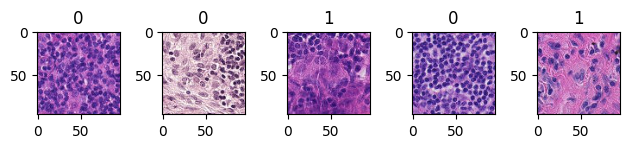

In [6]:
mostrar_imagenes(df, num_imagenes=5) 


In [8]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)  

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10, 
    zoom_range=0.2,             
    horizontal_flip=True,       
    fill_mode='nearest'         
)


valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='/kaggle/input/histopathologic-cancer-detection/train',
    x_col='id',
    y_col='label',
    target_size=(96,96),
    batch_size=32,
    class_mode='binary'
)


valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory='/kaggle/input/histopathologic-cancer-detection/train',
    x_col='id',
    y_col='label',
    batch_size=32, 
    target_size=(96,96),
    class_mode='binary'
)



Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [9]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(1, activation='sigmoid')(x) 

model = Model(inputs=base_model.input, outputs=x)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 102, 102,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 48, 48,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 48, 48,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 48, 48,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 50, 50,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 24, 24,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 24, 24,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 24, 24,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 24, 24,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 24, 24,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 24, 24,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 24, 24,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 24, 24,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 24, 24,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 24, 24,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 24, 24,    │      1,024 │ conv2_block1_3_c

 Total params: 33,025,921 (125.98 MB)

 Trainable params: 9,438,209 (36.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [10]:

early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

optimizer = Adam(learning_rate=0.00001)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


history = model.fit(
    train_generator,
    epochs=50,
    validation_data=valid_generator,  
    callbacks=[early_stopping],      
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1730391720.621593      71 service.cc:145] XLA service 0x7a4e0c0041e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730391720.621643      71 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1730391720.621646      71 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


   1/5501 ━━━━━━━━━━━━━━━━━━━━ 23:26:02 15s/step - accuracy: 0.4688 - loss: 2.2313

I0000 00:00:1730391726.711423      71 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1774s 320ms/step - accuracy: 0.8158 - loss: 0.4456 - val_accuracy: 0.8579 - val_loss: 0.3378
Epoch 2/50
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 815s 148ms/step - accuracy: 0.8699 - loss: 0.3071 - val_accuracy: 0.8622 - val_loss: 0.3290
Epoch 3/50
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 793s 144ms/step - accuracy: 0.8789 - loss: 0.2849 - val_accuracy: 0.8688 - val_loss: 0.3170
Epoch 4/50
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 812s 148ms/step - accuracy: 0.8862 - loss: 0.2751 - val_accuracy: 0.8666 - val_loss: 0.3283
Epoch 5/50
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 913s 166ms/step - accuracy: 0.8897 - loss: 0.2637 - val_accuracy: 0.8801 - val_loss: 0.2931
Epoch 6/50
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 905s 164ms/step - accuracy: 0.8926 - loss: 0.2574 - val_accuracy: 0.8832 - val_loss: 0.2903
Epoch 7/50
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 904s 164ms/step - accuracy: 0.8960 - loss: 0.2541 - val_accuracy: 0.8772 - val_loss: 0.3049
Epoch 8/50
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 923s 168ms/step - accuracy: 0.

In [11]:
model.save('rn7.h5')

##### 